In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import pi

# ==========================================
# 1. 全局参数配置 (Global Configuration)
# ==========================================
PARAMS = {
    'N_agents': 51200,        # 微观粒子数 (越大微观曲线越平滑)
    'K1': -0.5,             # 对应 epsilon1
    'K2': 3.0,              # 对应 epsilon2
    'gamma': 0.05,          # 洛伦兹分布宽度
    'omega0': 0.0,          # 中心频率
    'p0': 0.4,              # 初始比例
    'p_s': 0.4,             # 稳态比例
    'r1': 0.05,             # 速率 r_{2->1}
    'dt': 0.01,            # 微观时间步长
    't_max': 150.0,         # 模拟时长
    'seed': 43              # 随机种子
}

# 计算从属参数 r2
PARAMS['r2'] = (PARAMS['p_s'] * PARAMS['r1']) / (1 - PARAMS['p_s'])

# ==========================================
# 2. 通用函数库 (Functions)
# ==========================================
def sample_lorentzian(gamma, size):
    return gamma * np.random.standard_cauchy(size=size)

def get_p_analytic(t, p0, r1, r2):
    """解析解计算 p(t)"""
    sum_r = r1 + r2
    if sum_r == 0: return p0
    p_eq = r2 / sum_r
    return p_eq + (p0 - p_eq) * np.exp(-sum_r * t)

# --- 微观核心算法 ---
def heun_step_thetas(thetas, omegas, Ks, dt):
    Z = np.mean(np.exp(1j * thetas))
    R = np.abs(Z)
    phi = np.angle(Z)
    theta_dot = omegas + Ks * R * np.sin(phi - thetas)
    thetas_pred = thetas + dt * theta_dot
    Z_pred = np.mean(np.exp(1j * thetas_pred))
    R_pred = np.abs(Z_pred)
    phi_pred = np.angle(Z_pred)
    theta_dot_pred = omegas + Ks * R_pred * np.sin(phi_pred - thetas_pred)
    return thetas + dt * 0.5 * (theta_dot + theta_dot_pred)

def chemical_reaction(types, Ks, K1, K2, r1, r2, dt):
    N = len(types)
    n_pos = np.sum(types)
    n_neg = N - n_pos
    # Tau-leaping 泊松步
    n_p2n = np.random.poisson(r1 * n_pos * dt)
    n_n2p = np.random.poisson(r2 * n_neg * dt)
    n_p2n = min(n_p2n, n_pos)
    n_n2p = min(n_n2p, n_neg)
    
    if n_p2n > 0:
        idx = np.random.choice(np.where(types)[0], n_p2n, replace=False)
        types[idx] = False; Ks[idx] = K1
    if n_n2p > 0:
        idx = np.random.choice(np.where(~types)[0], n_n2p, replace=False)
        types[idx] = True; Ks[idx] = K2
    return types, Ks

# --- 宏观核心方程 ---
def macro_ode(t, y, N, p):
    m2 = get_p_analytic(t, p['p0'], p['r1'], p['r2'])
    m = [1.0 - m2, m2]
    A = [y[0:N], y[N:]]
    z = [np.conj(A[0][0]), np.conj(A[1][0])]
    Z = m[0]*z[0] + m[1]*z[1]
    h = [(p['K1']/2.0)*Z, (p['K2']/2.0)*Z]
    
    dAdt = []
    n_vec = np.arange(1, N + 1)
    for k in range(2):
        j = 1 - k
        A_plus = np.append(A[k][1:], 0.0)
        A_minus = np.insert(A[k][:-1], 0, 1.0+0j)
        term_lin = -n_vec * (1j*p['omega0'] + p['gamma']) * A[k]
        term_coup = -n_vec * h[k] * A_plus + n_vec * np.conj(h[k]) * A_minus
        
        rate = p['r1'] if k==0 else p['r2']
        ratio = m[j]/m[k] if m[k] > 1e-9 else 0
        term_flow = rate * ratio * (A[j] - A[k])
        dAdt.append(term_lin + term_coup + term_flow)
    return np.concatenate(dAdt)

print("Functions and Parameters defined.")

Functions and Parameters defined.


In [12]:
# ==========================================
# 运行微观模拟 (Microscopic Simulation)
# ==========================================
np.random.seed(PARAMS['seed'])

# 1. 初始化
types = np.random.rand(PARAMS['N_agents']) < PARAMS['p0']
Ks = np.where(types, PARAMS['K2'], PARAMS['K1'])
omegas = sample_lorentzian(PARAMS['gamma'], PARAMS['N_agents']) + PARAMS['omega0']
thetas = 2 * pi * np.random.rand(PARAMS['N_agents'])

# --- 关键：保存初始状态快照，用于宏观方程的初值映射 ---
micro_init_snapshot = {
    'thetas': thetas.copy(),
    'Ks': Ks.copy()
}

# 2. 时间演化
times = np.arange(0, PARAMS['t_max'], PARAMS['dt'])
history = {'t': times, 'R': [], 'R1': [], 'R2': [], 'p': []}

curr_types = types.copy()
curr_Ks = Ks.copy()
curr_thetas = thetas.copy()

print(f"Starting Micro simulation (N={PARAMS['N_agents']})...")

for i, t in enumerate(times):
    # 记录数据
    mask1 = (curr_Ks == PARAMS['K1'])
    mask2 = (curr_Ks == PARAMS['K2'])
    
    Z = np.mean(np.exp(1j * curr_thetas))
    Z1 = np.mean(np.exp(1j * curr_thetas[mask1])) if np.any(mask1) else 0
    Z2 = np.mean(np.exp(1j * curr_thetas[mask2])) if np.any(mask2) else 0
    
    history['R'].append(np.abs(Z))
    history['R1'].append(np.abs(Z1))
    history['R2'].append(np.abs(Z2))
    history['p'].append(np.mean(mask2))
    
    # 演化一步
    if i < len(times) - 1:
        curr_types, curr_Ks = chemical_reaction(curr_types, curr_Ks, 
                                              PARAMS['K1'], PARAMS['K2'], 
                                              PARAMS['r1'], PARAMS['r2'], PARAMS['dt'])
        curr_thetas = heun_step_thetas(curr_thetas, omegas, curr_Ks, PARAMS['dt'])

# 转换为数组方便绘图
micro_data = {k: np.array(v) for k, v in history.items()}
print("Micro simulation finished.")

Starting Micro simulation (N=51200)...
Micro simulation finished.


In [27]:
# ==========================================
# 运行宏观模拟 (Macroscopic Solver)
# ==========================================
import math

# -----------------------------
# 辅助：计算从 A_m 得到 varkappa_m 的初始值
# 关系： varkappa_m = A_m/(m-1)! - sum_{j=1}^{m-1} varkappa_{m-j} * A_j / j!
# 输入 A_vec 长度 N（A_1 ... A_N），返回长度 N 的 varkappa（复数）
# -----------------------------
def compute_kappa_from_A(A_vec):
    N = len(A_vec)
    kappa = np.zeros(N, dtype=complex)
    # 预计算阶乘 j! 和 (m-1)!（m从1..N）
    fact = [1] * (N + 1)
    for i in range(1, N + 1):
        fact[i] = fact[i-1] * i
    for m in range(1, N + 1):
        Am = A_vec[m-1]
        term = Am / fact[m-1]  # A_m/(m-1)!
        # subtract convolution
        if m > 1:
            s = 0+0j
            for j in range(1, m):
                # varkappa_{m-j} is kappa[m-j-1], A_j is A_vec[j-1]
                s += kappa[m-j-1] * (A_vec[j-1] / fact[j])
            term -= s
        kappa[m-1] = term
    return kappa

# -----------------------------
# 获取 r_{j->k}（与原脚本约定对应）
# 约定： r1 对应 (j=1 -> k=0), r2 对应 (j=0 -> k=1)
# -----------------------------
def get_r_j_to_k(j, k, params):
    if j == 1 and k == 0:
        return params['r1']
    if j == 0 and k == 1:
        return params['r2']
    return 0.0

# -----------------------------
# 新的宏观 RHS：基于 varkappa 层级方程
# y: concatenated [kappa^{(0)}_1..N, kappa^{(1)}_1..N]
# 返回 dy/dt 与 y 同型（长度 2N）
# -----------------------------
def my_kappa_rhs(t, y, N, params, m_func):
    # m_func(t, params) -> m2 或 (m1,m2)
    m2 = m_func(t, params)
    if isinstance(m2, (list, tuple, np.ndarray)) and len(m2) == 2:
        m = [m2[0], m2[1]]
    else:
        m = [1.0 - m2, m2]

    # 把 y 拆成两个群体的 kappa 向量
    kappa = [y[0:N].copy(), y[N:2*N].copy()]  # complex
    # z_k = conj(kappa_k[0]) 对应 \overline{\varkappa_1^{(k)}}
    z = [np.conj(kappa[0][0]), np.conj(kappa[1][0])]
    Z = m[0] * z[0] + m[1] * z[1]
    h = [(params['K1'] / 2.0) * Z, (params['K2'] / 2.0) * Z]
    # A coeff = i omega0 + gamma
    A_coeff = 1j * params['omega0'] + params['gamma']

    # 准备输出
    dY = np.zeros(2 * N, dtype=complex)

    # 预计算 Delta_kappa (for rho calculation) for each ordered pair (j->k)
    # We'll compute rho per pair when needed.
    for k_idx in (0, 1):
        j_idx = 1 - k_idx
        # Delta_q = kappa^{(j)}_q - kappa^{(k)}_q for q=1..N
        Delta = kappa[j_idx] - kappa[k_idx]

        # 计算 rho_m, m=0..N （rho_0 = 1）
        rho = np.zeros(N + 1, dtype=complex)
        rho[0] = 1.0 + 0j
        for mm in range(1, N + 1):
            s = 0+0j
            for q in range(1, mm + 1):
                s += rho[mm - q] * Delta[q - 1]
            rho[mm] = s / mm

        # D = r_{j->k} * (m_j / m_k)
        denom = m[k_idx] if (np.abs(m[k_idx]) > 1e-12) else 0.0
        rjto_k = get_r_j_to_k(j_idx, k_idx, params)
        D_coef = rjto_k * (m[j_idx] / denom) if denom != 0.0 else 0.0

        # 对每个 m = 1..N 计算 d/dt varkappa_m^{(k)}
        for m_idx in range(1, N + 1):
            km = kappa[k_idx][m_idx - 1]   # varkappa_m
            # first term: -A * m * varkappa_m
            term_A = -A_coeff * m_idx * km

            # second term: -B*m*( m*varkappa_{m+1} + sum_{l=1}^m v_l * v_{m+1-l} )
            B = h[k_idx]
            # varkappa_{m+1} truncated to 0 if m==N
            v_mplus1 = kappa[k_idx][m_idx] if m_idx < N else 0.0+0j
            # convolution sum
            conv = 0+0j
            for l in range(1, m_idx + 1):
                v_l = kappa[k_idx][l - 1]
                v_m1_l = kappa[k_idx][m_idx - l]  # index m+1-l -> m_idx - l +1 -1 = m_idx-l
                conv += v_l * v_m1_l
            term_B = -B * m_idx * (m_idx * v_mplus1 + conv)

            # C * delta_{m,1}  where C = h_k^*
            C_term = np.conj(h[k_idx]) if m_idx == 1 else 0.0+0j

            # D * m * rho_m
            term_D = D_coef * m_idx * rho[m_idx]

            dval = term_A + term_B + C_term + term_D
            dY[k_idx * N + (m_idx - 1)] = dval

    return dY

# -----------------------------
# 专门的运行器：用 varkappa 变量求解（自动把微观快照的 A 转为 varkappa 初值）
# 参数与之前 run_macro 类似
# -----------------------------
def run_macro_kappa_with_retry(N_orders_to_test, params, snapshot, t_eval=None,
                               macro_rhs_func=None, m_func=None, verbose=True):
    """
    Robust runner for the kappa-form macro ODEs with retries on failure.
    Attempts several solver/mode combinations when a solve fails.
    Returns macro_results dict like before.
    """
    if t_eval is None:
        t_eval = np.linspace(0, params['t_max'], 500)
    if m_func is None:
        def default_m_func_local(t, params_local):
            return get_p_analytic(t, params_local['p0'], params_local['r1'], params_local['r2'])
        m_func = default_m_func_local
    if macro_rhs_func is None:
        macro_rhs_func = my_kappa_rhs

    # solver attempts (ordered). You can tweak tolerances / max_step as needed.
    attempts = [
        {'method': 'BDF', 'rtol': 1e-6, 'atol': 1e-9, 'max_step': None},
        {'method': 'Radau', 'rtol': 1e-6, 'atol': 1e-9, 'max_step': None},
        # Looser tolerances + limit max_step to avoid tiny internal step blowups
        {'method': 'BDF', 'rtol': 1e-4, 'atol': 1e-7, 'max_step': max(params['dt'], 1e-3)},
        {'method': 'Radau', 'rtol': 1e-4, 'atol': 1e-7, 'max_step': max(params['dt'], 1e-3)},
        # As a last resort try explicit RK with small max_step
        {'method': 'RK45', 'rtol': 1e-6, 'atol': 1e-8, 'max_step': params['dt']}
    ]

    macro_results = {}
    for N in N_orders_to_test:
        if verbose: print(f"\n=== Running N={N} ===")
        # build initial A and kappa (same as before)
        init_thetas = snapshot['thetas']
        init_Ks = snapshot['Ks']
        mask1 = (init_Ks == params['K1'])
        mask2 = (init_Ks == params['K2'])
        thetas1 = init_thetas[mask1]
        thetas2 = init_thetas[mask2]
        n_vec = np.arange(1, N + 1)
        if len(thetas1) > 0:
            A1_init = np.array([np.mean(np.exp(1j * n * thetas1)) for n in n_vec], dtype=complex)
        else:
            A1_init = np.zeros(N, dtype=complex)
        if len(thetas2) > 0:
            A2_init = np.array([np.mean(np.exp(1j * n * thetas2)) for n in n_vec], dtype=complex)
        else:
            A2_init = np.zeros(N, dtype=complex)

        kappa1_init = compute_kappa_from_A(A1_init)
        kappa2_init = compute_kappa_from_A(A2_init)
        y0 = np.concatenate([kappa1_init, kappa2_init])

        # Diagnostic: check y0 and f(0,y0)
        def safe_eval_rhs_at_0():
            try:
                f0 = macro_rhs_func(0.0, y0, N, params, m_func)
                return f0
            except Exception as e:
                return e

        f0 = safe_eval_rhs_at_0()
        # Print diagnostics
        if verbose:
            print("Initial y0 norm:", np.linalg.norm(y0))
            if isinstance(f0, Exception):
                print("RHS evaluation at (t=0, y0) raised exception:", f0)
            else:
                print("RHS at t=0 statistics: norm =", np.linalg.norm(f0),
                      ", max abs =", np.max(np.abs(f0)))
            # detect NaN/Inf
            if np.any(np.isnan(y0)) or np.any(np.isinf(y0)):
                print("Warning: y0 contains NaN/Inf.")
            if not isinstance(f0, Exception) and (np.any(np.isnan(f0)) or np.any(np.isinf(f0))):
                print("Warning: RHS at t=0 contains NaN/Inf.")

        sol = None
        last_exception = None
        for attempt in attempts:
            method = attempt['method']
            rtol = attempt.get('rtol', 1e-6)
            atol = attempt.get('atol', 1e-9)
            max_step = attempt.get('max_step', None)
            if verbose:
                print(f"Trying solver method={method}, rtol={rtol}, atol={atol}, max_step={max_step}")

            try:
                sol = solve_ivp(lambda t, y: macro_rhs_func(t, y, N, params, m_func),
                                (0.0, params['t_max']), y0, t_eval=t_eval,
                                method=method, rtol=rtol, atol=atol,
                                max_step=max_step if max_step is not None else np.inf)
                # If solver reports success and solution finite -> accept
                if sol.success and not np.any(np.isnan(sol.y)) and not np.any(np.isinf(sol.y)):
                    if verbose: print(f" -> N={N} Solved (method={method}).")
                    break
                else:
                    # solver returned but indicates issues
                    last_exception = RuntimeError(f"Solver returned success={sol.success}, message={sol.message}")
                    if verbose:
                        print(f"Solver exit: success={sol.success}, message={sol.message}")
                        # small sanity check of first few values
                        try:
                            print("Solution y (first column) abs norm:", np.linalg.norm(sol.y[:, 0]))
                        except Exception:
                            pass
            except Exception as e:
                last_exception = e
                if verbose:
                    print(f" -> attempt failed with exception: {repr(e)}")
                # continue to next attempt

        # after attempts
        if sol is not None and sol.success and not (np.any(np.isnan(sol.y)) or np.any(np.isinf(sol.y))):
            z1 = np.conj(sol.y[0])
            z2 = np.conj(sol.y[N])
            m2 = m_func(sol.t, params)
            if isinstance(m2, (list, tuple, np.ndarray)) and len(m2) == 2:
                m1 = m2[0]; m2v = m2[1]
            else:
                m2v = m2; m1 = 1.0 - m2v
            Z = m1 * z1 + m2v * z2
            macro_results[N] = {'t': sol.t, 'R': np.abs(Z), 'R1': np.abs(z1), 'R2': np.abs(z2)}
        else:
            # All attempts failed
            if verbose:
                print(f" -> N={N} All attempts failed.")
                if last_exception is not None:
                    print("Last exception / info:", repr(last_exception))
            # return a placeholder with NaNs so downstream plotting doesn't crash
            ts = t_eval
            macro_results[N] = {'t': ts, 'R': np.full_like(ts, np.nan, dtype=float),
                                'R1': np.full_like(ts, np.nan, dtype=float),
                                'R2': np.full_like(ts, np.nan, dtype=float)}
    return macro_results

  

N_orders_to_test = [1,2,5]
t_eval = np.linspace(0, PARAMS['t_max'], 150)
macro_results = run_macro_kappa_with_retry(N_orders_to_test, PARAMS, micro_init_snapshot, t_eval=t_eval)
print("Macro simulation (kappa form) finished.")



=== Running N=1 ===
Initial y0 norm: 0.01057744571041674
RHS at t=0 statistics: norm = 0.0026738818792316674 , max abs = 0.002671820364244629
Trying solver method=BDF, rtol=1e-06, atol=1e-09, max_step=None
 -> N=1 Solved (method=BDF).

=== Running N=2 ===
Initial y0 norm: 0.010925937047399772
RHS at t=0 statistics: norm = 0.0026975900432360156 , max abs = 0.0026767731415306153
Trying solver method=BDF, rtol=1e-06, atol=1e-09, max_step=None
 -> N=2 Solved (method=BDF).

=== Running N=5 ===
Initial y0 norm: 0.012750574253985939
RHS at t=0 statistics: norm = 0.0029350957869276003 , max abs = 0.0026767731415306153
Trying solver method=BDF, rtol=1e-06, atol=1e-09, max_step=None
Solver exit: success=False, message=Required step size is less than spacing between numbers.
Solution y (first column) abs norm: 0.012750574253985939
Trying solver method=Radau, rtol=1e-06, atol=1e-09, max_step=None
 -> attempt failed with exception: ValueError('`y0` is complex, but the chosen solver does not suppor

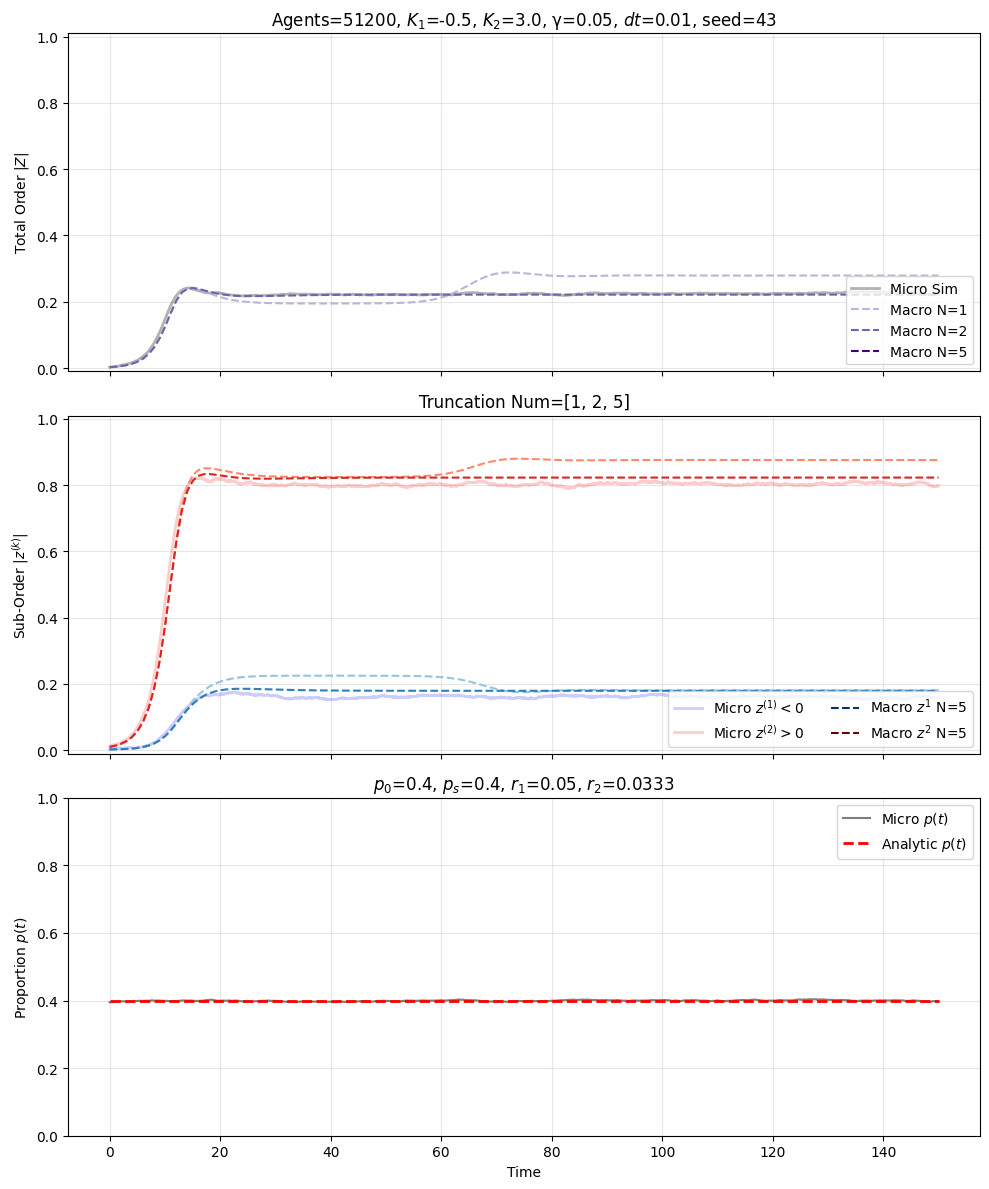

In [28]:
# ==========================================
# 绘图 (Visualization)
# ==========================================
def get_color(idx, total, cmap_name):
    # 获取渐变色：从浅到深 (0.4 -> 1.0)
    cmap = plt.get_cmap(cmap_name)
    return cmap(0.4 + 0.6 * (idx / max(1, total - 1)))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# --- 1. 上图: 总序参量 Z ---
# 微观 (实线)
ax1.plot(micro_data['t'], micro_data['R'], 'k-', alpha=0.3, linewidth=2, label='Micro Sim')

# 宏观 (虚线, 紫色系)
sorted_N = sorted(N_orders_to_test)
for i, N in enumerate(sorted_N):
    res = macro_results[N]
    col = get_color(i, len(sorted_N), 'Purples')
    ax1.plot(res['t'], res['R'], linestyle='--', color=col, 
             linewidth=1.5, label=f'Macro N={N}')

ax1.set_ylabel(r'Total Order $|Z|$')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.01, 1.01)
ax1.set_title(f"Agents={PARAMS['N_agents']}, $K_1$={PARAMS['K1']}, $K_2$={PARAMS['K2']}, γ={PARAMS['gamma']}, $dt$={PARAMS['dt']}, seed={PARAMS['seed']}")

# --- 2. 中图: 子群体序参量 ---
# 微观
ax2.plot(micro_data['t'], micro_data['R1'], color='blue', alpha=0.2, linewidth=2, label='Micro $z^{(1)}<0$')
ax2.plot(micro_data['t'], micro_data['R2'], color='red', alpha=0.2, linewidth=2, label='Micro $z^{(2)}>0$')

# 宏观
for i, N in enumerate(sorted_N):
    res = macro_results[N]
    # 冷色系 -> z1 (K1=-0.5)
    c_z1 = get_color(i, len(sorted_N), 'Blues')
    # 暖色系 -> z2 (K2=1.0)
    c_z2 = get_color(i, len(sorted_N), 'Reds')
    
    # 只给最后一个 N 加图例，避免图例太乱
    lbl_1 = f'Macro $z^{(1)}$ N={N}' if i == len(sorted_N)-1 else None
    lbl_2 = f'Macro $z^{(2)}$ N={N}' if i == len(sorted_N)-1 else None
    
    ax2.plot(res['t'], res['R1'], linestyle='--', color=c_z1, linewidth=1.5, label=lbl_1)
    ax2.plot(res['t'], res['R2'], linestyle='--', color=c_z2, linewidth=1.5, label=lbl_2)

ax2.set_ylabel(r'Sub-Order $|z^{(k)}|$')
ax2.legend(loc='lower right', ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.01, 1.01)
ax2.set_title(f"Truncation Num={sorted_N}")

# --- 3. 下图: 质量 p(t) ---
# 微观
ax3.plot(micro_data['t'], micro_data['p'], 'k-', alpha=0.5, label='Micro $p(t)$')
# 解析 (与 N 无关，只画一条)
t_theory = np.linspace(0, PARAMS['t_max'], 200)
p_theory = get_p_analytic(t_theory, PARAMS['p0'], PARAMS['r1'], PARAMS['r2'])
ax3.plot(t_theory, p_theory, 'r--', linewidth=2, label='Analytic $p(t)$')

ax3.set_ylabel('Proportion $p(t)$')
ax3.set_xlabel('Time')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.0)
ax3.set_title(f"$p_0$={PARAMS['p0']}, $p_s$={PARAMS['p_s']}, $r_1$={PARAMS['r1']}, $r_2$={PARAMS['r2']:.4f}")

plt.tight_layout()
plt.show()